## 2D QSAR

**Two-stage QSAR approach** for the ACHE dataset:

1. Split data into Train (80%) and Test (20%).
2. Perform 10-fold Cross-Validation on the TRAIN set.
3. Retrain on the entire TRAIN set.
4. Evaluate on the TEST set (20% hold-out).

There are **two scenarios**:
- Scenario I (Actives + Inactives)
- Scenario II (Actives + Inactives + Decoys)

Results obtained are:
- Mean Accuracy / AUC in 10-fold CV
- Final test set metrics (Accuracy, AUC, EF1%, NEF1%)
- ROC curves on the test set.


### 1. Loading required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, PandasTools, Draw, rdMolDescriptors
from rdkit.Chem.GraphDescriptors import Chi0n, Chi1n, Chi2n, Chi3n, Chi4n
from rdkit.Chem.rdMolDescriptors import CalcLabuteASA
from rdkit.Chem.Lipinski import RingCount

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import optuna
import joblib

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    balanced_accuracy_score,
    matthews_corrcoef,
    f1_score,
    confusion_matrix
)

# Attempt XGBoost
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost is not installed. Please install via: pip install xgboost")
    XGBClassifier = None


### 2. Defining functions for data preparation and descriptors

In [2]:
def load_smiles_file(url):
    """Loads a .smi file (SMILES, ID) from URL."""
    df = pd.read_csv(url, sep=" ", names=["SMILES", "ID"], header=None)
    return df

def compute_morgan_fp(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return None

def fp_to_numpy(fp):
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def compute_additional_descriptors(smiles):
    """
    Computes additional 2D descriptors:
    - SLogP, LabuteASA, RingCount
    - Chi0n, Chi1n, Chi2n, Chi3n, Chi4n
    """
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return {
            "SLogP": np.nan,
            "LabuteASA": np.nan,
            "RingCount": np.nan,
            "Chi0n": np.nan,
            "Chi1n": np.nan,
            "Chi2n": np.nan,
            "Chi3n": np.nan,
            "Chi4n": np.nan,
        }
    return {
        "SLogP": Descriptors.MolLogP(mol),
        "LabuteASA": CalcLabuteASA(mol),
        "RingCount": RingCount(mol),
        "Chi0n": Chi0n(mol),
        "Chi1n": Chi1n(mol),
        "Chi2n": Chi2n(mol),
        "Chi3n": Chi3n(mol),
        "Chi4n": Chi4n(mol),
    }

def prepare_dataframe(df):
    """Computes Morgan fingerprints + additional descriptors."""
    tmp = df.copy()

    # Morgan FP
    tmp["Morgan_fp"] = tmp["SMILES"].apply(compute_morgan_fp)
    tmp.dropna(subset=["Morgan_fp"], inplace=True)

    # Additional descriptors
    extras = tmp["SMILES"].apply(compute_additional_descriptors)
    extras_df = pd.DataFrame(list(extras))

    # Merge
    tmp = pd.concat([tmp.reset_index(drop=True), extras_df.reset_index(drop=True)], axis=1)
    return tmp

def create_feature_matrix(df, actives_set):
    """Converts Morgan + descriptors to X, and Label column to y."""
    # Label: 1=Active, 0=Inactive
    df["Label"] = df["ID"].apply(lambda x: 1 if x in actives_set else 0)

    # Convert FP to numpy array
    fp_arr = df["Morgan_fp"].apply(fp_to_numpy)
    fp_mat = np.stack(fp_arr.values)

    # Additional descriptor columns
    desc_cols = ["SLogP", "LabuteASA", "RingCount", "Chi0n", "Chi1n", "Chi2n", "Chi3n", "Chi4n"]
    desc_mat = df[desc_cols].values

    X = np.hstack([fp_mat, desc_mat])
    y = df["Label"].values
    return X, y

def preprocess(X_train, X_test):

    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    #remove highly correlated features
    corr_matrix = X_train.corr()
    up_triangle = pd.DataFrame(np.triu(corr_matrix, k = 1))
    column_corr = [col for col in up_triangle.columns if any(abs(up_triangle[col]) >= 0.99)]

    #remove constant features
    columns_var = X_train.loc[:, X_train.var() == 0].columns


    col_to_drop = np.concatenate([column_corr, columns_var])

    X_train_drop = X_train.drop(col_to_drop, axis = 1)
    X_test_drop = X_test.drop(col_to_drop, axis = 1)

    minmax = MinMaxScaler()
    minmax.fit(X_train_drop)

    X_train_scaled = minmax.transform(X_train_drop)
    X_test_scaled = minmax.transform(X_test_drop)

    return pd.DataFrame(X_train_scaled, columns=X_train_drop.columns), pd.DataFrame(X_test_scaled, columns=X_test_drop.columns)

### 3. Functions for 10-Fold CV, EF1%/NEF1%

In [3]:
def cv_10fold(X, y, model):
    """Performs 10-fold CV on the given model and returns mean Accuracy, mean AUC."""
    
    y_pred = cross_val_predict(model, X, y, cv = 10, method = 'predict_proba')

    y_prob = y_pred[:,1]
    y_pred_ = (y_pred[:, 1] >= 0.7).astype(int) 
    
    acc = accuracy_score(y, y_pred_)
    auc_val = roc_auc_score(y, y_prob)
    bacc = balanced_accuracy_score(y, y_pred_)
    f1 = f1_score(y, y_pred_)
    mcc = matthews_corrcoef(y, y_pred_)

    return acc, auc_val, bacc, f1, mcc

def compute_ef1_nef1(y_true, y_prob, top_percent=1):
    """Computes EF1% and NEF1% given true labels and probabilities."""
    sorted_idx = np.argsort(-y_prob)  # descending
    y_sorted = y_true[sorted_idx]

    N = len(y_sorted)
    n = max(1, N // (100 // top_percent))
    A = (y_true == 1).sum()
    a = (y_sorted[:n] == 1).sum()

    EF1 = (100 * a / A) if A > 0 else 0
    EF1max = min(100, 100.0 * n / A) if (A>0 and n>0) else 100
    NEF1 = EF1 / EF1max if EF1max > 0 else 0

    return EF1, NEF1

### 4. Loading and preparing scenarios

In [4]:
base_url = "https://raw.githubusercontent.com/vktrannguyen/MLSF-protocol/main/ACHE/Own_data/SMILES/"
files = {
    "actives": "ACHE-actives.smi",
    "inactives": "ACHE-inactives.smi",
    "decoys": "ACHE-decoys-selected.smi"
}

# Load raw data
ache_actives   = load_smiles_file(base_url + files["actives"])
ache_inactives = load_smiles_file(base_url + files["inactives"])
ache_decoys    = load_smiles_file(base_url + files["decoys"])

# Build scenario data
scenario1_raw = pd.concat([ache_actives, ache_inactives], ignore_index=True)
scenario2_raw = pd.concat([ache_actives, ache_inactives, ache_decoys], ignore_index=True)

print("Scenario I => total rows:", len(scenario1_raw))
print("Scenario II => total rows:", len(scenario2_raw))

# Prepare data (fingerprints + descriptors)
scenario1_df = prepare_dataframe(scenario1_raw)
scenario2_df = prepare_dataframe(scenario2_raw)

print("Scenario I => valid rows:", len(scenario1_df))
print("Scenario II => valid rows:", len(scenario2_df))

# Create feature matrices
actives_set = set(ache_actives["ID"].values)
X1, y1 = create_feature_matrix(scenario1_df, actives_set)
X2, y2 = create_feature_matrix(scenario2_df, actives_set)

Scenario I => total rows: 368
Scenario II => total rows: 8867


[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerator
[15:05:59] DEPRECATION WARNING: please use MorganGenerat

Scenario I => valid rows: 368
Scenario II => valid rows: 8867


### 5. Defining inputs

In [5]:
# Split 80/20
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, stratify=y1, random_state=42
)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, stratify=y2, random_state=42
)

print(f"\nScenario I => Train: {len(X1_train)}, Test: {len(X1_test)}")
print(f"Scenario II => Train: {len(X2_train)}, Test: {len(X2_test)}")

X1_train_scaled, X1_test_scaled = preprocess(X1_train, X1_test)
X2_train_scaled, X2_test_scaled = preprocess(X2_train, X2_test)
X2_train_scaled, X2_scaled = preprocess(X2_train, X2)


Scenario I => Train: 294, Test: 74
Scenario II => Train: 7093, Test: 1774


### 6. Hyperparameter tuning

In [120]:
def objective_RF(trial):

    n_estimators = trial.suggest_int('n_estimators', 1, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    model = RandomForestClassifier(n_estimators=n_estimators, 
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   random_state=36)
    
    threshold = 0.7

    y_pred = cross_val_predict(model, X1_train_scaled, y1_train, cv=10, method='predict_proba')
    y_pred_ = (y_pred[:, 1] >= threshold).astype(int) 

    return matthews_corrcoef(y1_train, y_pred_)

study_RF = optuna.create_study(direction='maximize', sampler = optuna.samplers.RandomSampler(seed=52)) 
study_RF.optimize(objective_RF, n_trials=1000)

print("Best hyperparameters:", study_RF.best_params)
print("Best value:", study_RF.best_value)

joblib.dump(study_RF, "scene1_RF.pkl") 

[I 2025-03-10 12:19:23,224] A new study created in memory with name: no-name-2658878d-9d46-4afb-8921-d72dc596b02f
[I 2025-03-10 12:19:27,276] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 412, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.
[I 2025-03-10 12:19:27,628] Trial 1 finished with value: 0.36409723128244514 and parameters: {'n_estimators': 27, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 1 with value: 0.36409723128244514.
[I 2025-03-10 12:19:32,087] Trial 2 finished with value: 0.5035951597551744 and parameters: {'n_estimators': 383, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5035951597551744.
[I 2025-03-10 12:19:34,341] Trial 3 finished with value: 0.5627952429974793 and parameters: {'n_estimators': 185, 'max_depth': 18, 'min_samples_split': 9, 'min_

Best hyperparameters: {'n_estimators': 452, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best value: 0.6968061044479291


['scene1_RF.pkl']

In [121]:
def objective_XGB(trial):

    eta  = trial.suggest_float('eta', 0, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_child_weight = trial.suggest_int("min_child_weight", 2, 10)
    subsample = trial.suggest_float("subsample", 0, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0, 1)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 1)


    model = XGBClassifier(eta = eta, gamma = gamma, max_depth = max_depth,
                          min_child_weight = min_child_weight,
                          subsample = subsample, colsample_bytree = colsample_bytree,
                          reg_alpha = reg_alpha, reg_lambda = reg_lambda,
                          random_state = 36)
    
    threshold = 0.7

    y_pred = cross_val_predict(model, X1_train_scaled, y1_train, cv=10, method='predict_proba')
    y_pred_ = (y_pred[:, 1] >= threshold).astype(int) 

    return matthews_corrcoef(y1_train, y_pred_)


study_XGB = optuna.create_study(direction='maximize', sampler = optuna.samplers.RandomSampler(seed=36)) 
study_XGB.optimize(objective_XGB, n_trials=1000)

print("Best hyperparameters:", study_XGB.best_params)
print("Best value:", study_XGB.best_value)
joblib.dump(study_XGB, "scene1_XGB.pkl") 

[I 2025-03-10 13:13:19,492] A new study created in memory with name: no-name-0c7eb8f6-b194-4215-8182-d9efb9cf34f6
[I 2025-03-10 13:13:29,817] Trial 0 finished with value: 0.6264605575682153 and parameters: {'eta': 0.7285071915957256, 'gamma': 0.6016142123702133, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.8073591298701648, 'colsample_bytree': 0.36321459652102894, 'reg_alpha': 0.18655681228931587, 'reg_lambda': 0.25915123828794717}. Best is trial 0 with value: 0.6264605575682153.
[I 2025-03-10 13:13:39,951] Trial 1 finished with value: 0.47063758857888993 and parameters: {'eta': 0.6297623426119493, 'gamma': 0.03256092153892931, 'max_depth': 19, 'min_child_weight': 10, 'subsample': 0.5501301556218323, 'colsample_bytree': 0.19700828764074718, 'reg_alpha': 0.23203283149672627, 'reg_lambda': 0.0023659750442113214}. Best is trial 0 with value: 0.6264605575682153.
[I 2025-03-10 13:13:51,607] Trial 2 finished with value: 0.530465737523587 and parameters: {'eta': 0.22605554497448566,

Best hyperparameters: {'eta': 0.47789500911925575, 'gamma': 0.4129150384278477, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6460639514162748, 'colsample_bytree': 0.2829608281280298, 'reg_alpha': 0.24534833867413497, 'reg_lambda': 0.8489674653408457}
Best value: 0.7346078315897001


['scene1_XGB.pkl']

In [122]:
def objective_RF(trial):

    n_estimators = trial.suggest_int('n_estimators', 1, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    model = RandomForestClassifier(n_estimators=n_estimators, 
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   random_state=36)
    
    threshold = 0.7

    y_pred = cross_val_predict(model, X2_train_scaled, y2_train, cv=10, method='predict_proba')
    y_pred_ = (y_pred[:, 1] >= threshold).astype(int) 

    return matthews_corrcoef(y2_train, y_pred_)

study_RF = optuna.create_study(direction='maximize', sampler = optuna.samplers.RandomSampler(seed=12)) 
study_RF.optimize(objective_RF, n_trials=1000)

print("Best hyperparameters:", study_RF.best_params)
print("Best value:", study_RF.best_value)

joblib.dump(study_RF, "scene2_RF.pkl") 

[I 2025-03-10 15:34:15,275] A new study created in memory with name: no-name-5ba1179c-3d7e-4ff2-bc15-6f200c1d6e02
[I 2025-03-10 15:34:18,696] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 78, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.
[I 2025-03-10 15:34:26,472] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 451, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.
[I 2025-03-10 15:35:17,538] Trial 2 finished with value: 0.33688193780417514 and parameters: {'n_estimators': 473, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.33688193780417514.
[I 2025-03-10 15:35:43,253] Trial 3 finished with value: 0.37914313952332374 and parameters: {'n_estimators': 385, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_featur

Best hyperparameters: {'n_estimators': 436, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best value: 0.6493414345005679


['scene2_RF.pkl']

In [6]:
def objective_XGB(trial):

    eta  = trial.suggest_float('eta', 0, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_child_weight = trial.suggest_int("min_child_weight", 2, 10)
    subsample = trial.suggest_float("subsample", 0, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0, 1)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 1)


    model = XGBClassifier(eta = eta, gamma = gamma, max_depth = max_depth,
                          min_child_weight = min_child_weight,
                          subsample = subsample, colsample_bytree = colsample_bytree,
                          reg_alpha = reg_alpha, reg_lambda = reg_lambda,
                          random_state = 36)
    
    threshold = 0.7

    y_pred = cross_val_predict(model, X2_train_scaled, y2_train, cv=10, method='predict_proba')
    y_pred_ = (y_pred[:, 1] >= threshold).astype(int) 

    return matthews_corrcoef(y2_train, y_pred_)


study_XGB = optuna.create_study(direction='maximize', sampler = optuna.samplers.RandomSampler(seed=25)) 
study_XGB.optimize(objective_XGB, n_trials=1000)

print("Best hyperparameters:", study_XGB.best_params)
print("Best value:", study_XGB.best_value)
joblib.dump(study_XGB, "scene2_XGB.pkl") 

[I 2025-03-11 16:32:09,690] A new study created in memory with name: no-name-5c0be622-152b-4540-bb39-ed75905b3b09
[I 2025-03-11 16:32:22,811] Trial 0 finished with value: 0.5737169570998019 and parameters: {'eta': 0.8701241366272119, 'gamma': 0.5822769286725598, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.4111001279251132, 'colsample_bytree': 0.11737554713471554, 'reg_alpha': 0.684968744374135, 'reg_lambda': 0.4376110596596504}. Best is trial 0 with value: 0.5737169570998019.
[I 2025-03-11 16:32:35,801] Trial 1 finished with value: 0.6768685418067737 and parameters: {'eta': 0.5562293251719702, 'gamma': 0.3670803216193239, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.44703084626748935, 'colsample_bytree': 0.5854451165110357, 'reg_alpha': 0.16198510384493825, 'reg_lambda': 0.5207187880526836}. Best is trial 1 with value: 0.6768685418067737.
[I 2025-03-11 16:32:48,157] Trial 2 finished with value: 0.5580863164854679 and parameters: {'eta': 0.3260511261378255, 'gamma': 0

Best hyperparameters: {'eta': 0.4394918447239142, 'gamma': 0.11763725329415431, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9011083133140654, 'colsample_bytree': 0.6057172376668051, 'reg_alpha': 0.6287720185486873, 'reg_lambda': 0.45962169384935037}
Best value: 0.7670529495683509


['scene2_XGB.pkl']

In [8]:
# Models
jl_RF1 = joblib.load('scene1_RF.pkl')
jl_XGB1 = joblib.load('scene1_XGB.pkl')

jl_RF2 = joblib.load('scene2_RF.pkl')
jl_XGB2 = joblib.load('scene2_XGB.pkl')

models = [{
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(**jl_RF1.best_params, random_state=36),
    "XGBoost": XGBClassifier(**jl_XGB1.best_params, random_state = 36)
},
        { 
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(**jl_RF2.best_params, random_state=36),
    "XGBoost": XGBClassifier(**jl_XGB2.best_params, random_state = 36)
}]


# defining scenario mapping
scenarios = [{
    "Scenario I": (X1_train_scaled, X1_test_scaled, y1_train, y1_test)},
{
    "Scenario II": (X2_train_scaled, X2_test_scaled, y2_train, y2_test)
}]

### 7. Run two-stage validation for each scenario and model
- **Stage 1:** 10-fold CV on the training portion
- **Stage 2:** Retrain on the full training set
- **Stage 3:** Evaluate once on the test set
- **Stage 4:** Plot ROC curve for that final test


===== Scenario I =====
Training set: 294 | Test set: 74

Model: Logistic Regression
   [TRAIN] Accuracy=0.942, BalancedAcc=0.940, MCC=0.884, F1=0.935, AUC=0.993, EF1%=1.48, NEF1%=1.00
   [CV] Mean Accuracy = 0.847, Mean AUC = 0.948, BACC = 0.841, f1 = 0.822, mcc = 0.694
   [TEST] Accuracy=0.878, BalancedAcc=0.870, MCC=0.766, F1=0.852, AUC=0.899, EF1%=2.94, NEF1%=1.00
              precision    recall  f1-score   support

           0       0.83      0.97      0.90        40
           1       0.96      0.76      0.85        34

    accuracy                           0.88        74
   macro avg       0.90      0.87      0.87        74
weighted avg       0.89      0.88      0.88        74



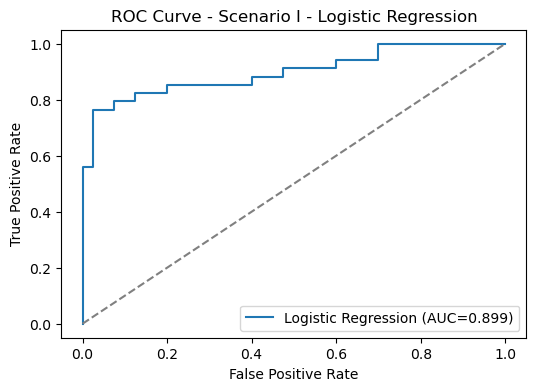

[[154   5]
 [ 12 123]]
[[39  1]
 [ 8 26]]

Model: Random Forest
   [TRAIN] Accuracy=0.990, BalancedAcc=0.989, MCC=0.980, F1=0.989, AUC=1.000, EF1%=1.48, NEF1%=1.00
   [CV] Mean Accuracy = 0.844, Mean AUC = 0.945, BACC = 0.834, f1 = 0.807, mcc = 0.697
   [TEST] Accuracy=0.851, BalancedAcc=0.840, MCC=0.717, F1=0.814, AUC=0.907, EF1%=2.94, NEF1%=1.00
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        40
           1       0.96      0.71      0.81        34

    accuracy                           0.85        74
   macro avg       0.88      0.84      0.84        74
weighted avg       0.87      0.85      0.85        74



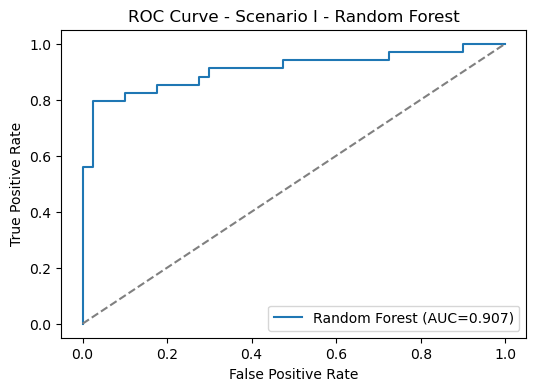

[[159   0]
 [  3 132]]
[[39  1]
 [10 24]]

Model: XGBoost
   [TRAIN] Accuracy=0.959, BalancedAcc=0.957, MCC=0.918, F1=0.955, AUC=0.998, EF1%=1.48, NEF1%=1.00
   [CV] Mean Accuracy = 0.867, Mean AUC = 0.935, BACC = 0.862, f1 = 0.847, mcc = 0.735
   [TEST] Accuracy=0.851, BalancedAcc=0.840, MCC=0.717, F1=0.814, AUC=0.865, EF1%=2.94, NEF1%=1.00
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        40
           1       0.96      0.71      0.81        34

    accuracy                           0.85        74
   macro avg       0.88      0.84      0.84        74
weighted avg       0.87      0.85      0.85        74



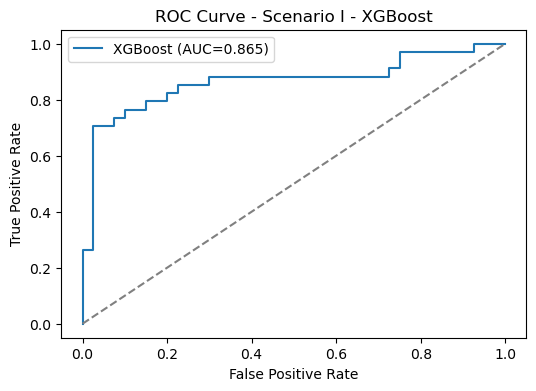

[[156   3]
 [  9 126]]
[[39  1]
 [10 24]]

===== Scenario II =====
Training set: 7093 | Test set: 1774

Model: Logistic Regression
   [TRAIN] Accuracy=0.997, BalancedAcc=0.926, MCC=0.906, F1=0.906, AUC=1.000, EF1%=51.85, NEF1%=1.00
   [CV] Mean Accuracy = 0.991, Mean AUC = 0.995, BACC = 0.814, f1 = 0.733, mcc = 0.739
   [TEST] Accuracy=0.994, BalancedAcc=0.882, MCC=0.840, F1=0.839, AUC=0.999, EF1%=47.06, NEF1%=0.94
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1740
           1       0.93      0.76      0.84        34

    accuracy                           0.99      1774
   macro avg       0.96      0.88      0.92      1774
weighted avg       0.99      0.99      0.99      1774



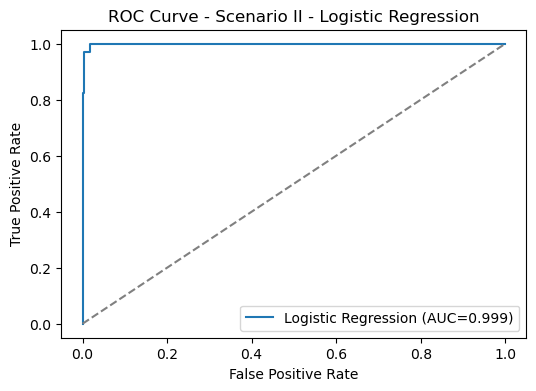

[[6954    4]
 [  20  115]]
[[1738    2]
 [   8   26]]

Model: Random Forest
   [TRAIN] Accuracy=0.996, BalancedAcc=0.896, MCC=0.888, F1=0.884, AUC=1.000, EF1%=51.85, NEF1%=1.00
   [CV] Mean Accuracy = 0.989, Mean AUC = 0.992, BACC = 0.737, f1 = 0.621, mcc = 0.649
   [TEST] Accuracy=0.993, BalancedAcc=0.838, MCC=0.802, F1=0.793, AUC=0.998, EF1%=50.00, NEF1%=1.00
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1740
           1       0.96      0.68      0.79        34

    accuracy                           0.99      1774
   macro avg       0.98      0.84      0.89      1774
weighted avg       0.99      0.99      0.99      1774



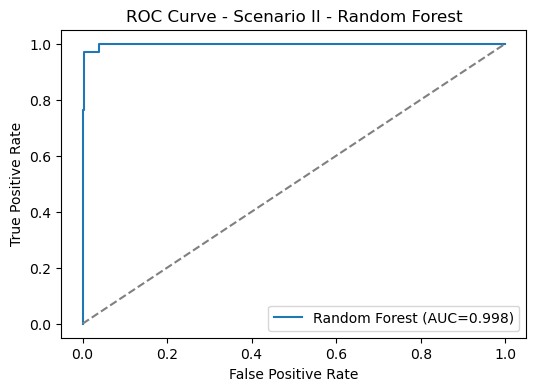

[[6958    0]
 [  28  107]]
[[1739    1]
 [  11   23]]

Model: XGBoost
   [TRAIN] Accuracy=0.999, BalancedAcc=0.967, MCC=0.962, F1=0.962, AUC=1.000, EF1%=51.85, NEF1%=1.00
   [CV] Mean Accuracy = 0.992, Mean AUC = 0.991, BACC = 0.833, f1 = 0.763, mcc = 0.767
   [TEST] Accuracy=0.993, BalancedAcc=0.924, MCC=0.825, F1=0.829, AUC=0.994, EF1%=47.06, NEF1%=0.94
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1740
           1       0.81      0.85      0.83        34

    accuracy                           0.99      1774
   macro avg       0.90      0.92      0.91      1774
weighted avg       0.99      0.99      0.99      1774



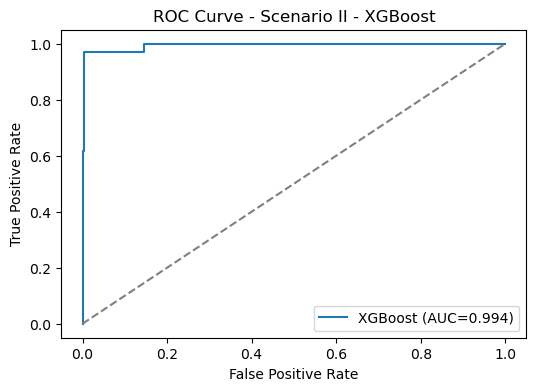

[[6957    1]
 [   9  126]]
[[1733    7]
 [   5   29]]


In [10]:
for i in range(2):
    for scenario_label, (Xtr, Xte, Ytr, Yte) in scenarios[i].items():
        print(f"\n===== {scenario_label} =====")
        print(f"Training set: {len(Xtr)} | Test set: {len(Xte)}")

        for model_name, model_obj in models[i].items():
            print(f"\nModel: {model_name}")

            # 1) 10-fold CV on TRAIN
            mean_acc, mean_auc, bacc, f1, mcc = cv_10fold(Xtr, Ytr, model_obj)

            # 2) Retrain on full TRAIN
            final_clf = clone(model_obj)
            final_clf.fit(Xtr, Ytr)

            # 3) Evaluate on TRAIN/TEST
            try:
                y_prob_train = final_clf.predict_proba(Xtr)[:,1]
            except:
                cal_clf = CalibratedClassifierCV(final_clf, cv="prefit")
                cal_clf.fit(Xtr, Ytr)
                y_prob_train = cal_clf.predict_proba(Xtr)[:,1]

            try:
                y_prob_test = final_clf.predict_proba(Xte)[:,1]
            except:
                cal_clf = CalibratedClassifierCV(final_clf, cv="prefit")
                cal_clf.fit(Xtr, Ytr)
                y_prob_test = cal_clf.predict_proba(Xte)[:,1]


            y_pred_train = (y_prob_train >= 0.7).astype(int)
            y_pred_test = (y_prob_test >= 0.7).astype(int)

            train_acc = accuracy_score(Ytr, y_pred_train)
            test_acc = accuracy_score(Yte, y_pred_test)

            train_auc = roc_auc_score(Ytr, y_prob_train)
            test_auc = roc_auc_score(Yte, y_prob_test)
            
            EF1_train, NEF1_train = compute_ef1_nef1(Ytr, y_prob_train)
            EF1_test, NEF1_test = compute_ef1_nef1(Yte, y_prob_test)

            bal_acc_train = balanced_accuracy_score(Ytr, y_pred_train)
            bal_acc_test = balanced_accuracy_score(Yte, y_pred_test)

            mcc_train = matthews_corrcoef(Ytr, y_pred_train)
            mcc_test = matthews_corrcoef(Yte, y_pred_test)

            f1_train = f1_score(Ytr, y_pred_train)
            f1_test = f1_score(Yte, y_pred_test)

            print(f"   [TRAIN] Accuracy={train_acc:.3f}, BalancedAcc={bal_acc_train:.3f}, "
                f"MCC={mcc_train:.3f}, F1={f1_train:.3f}, AUC={train_auc:.3f}, EF1%={EF1_train:.2f}, NEF1%={NEF1_train:.2f}")

            print(f"   [CV] Mean Accuracy = {mean_acc:.3f}, Mean AUC = {mean_auc:.3f}, BACC = {bacc:.3f}, f1 = {f1:.3f}, mcc = {mcc:.3f}")

            print(f"   [TEST] Accuracy={test_acc:.3f}, BalancedAcc={bal_acc_test:.3f}, "
                f"MCC={mcc_test:.3f}, F1={f1_test:.3f}, AUC={test_auc:.3f}, EF1%={EF1_test:.2f}, NEF1%={NEF1_test:.2f}")
            
            print(classification_report(Yte, y_pred_test))

            # 4) Plot ROC for the TEST set
            fpr, tpr, _ = roc_curve(Yte, y_prob_test)
            plt.figure(figsize=(6,4))
            plt.plot(fpr, tpr, label=f"{model_name} (AUC={test_auc:.3f})")
            plt.plot([0,1],[0,1],'--', color='gray')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {scenario_label} - {model_name}")
            plt.legend()
            plt.show()

            print(confusion_matrix(Ytr, y_pred_train)) 
            print(confusion_matrix(Yte, y_pred_test))

### 8. Applicability domain

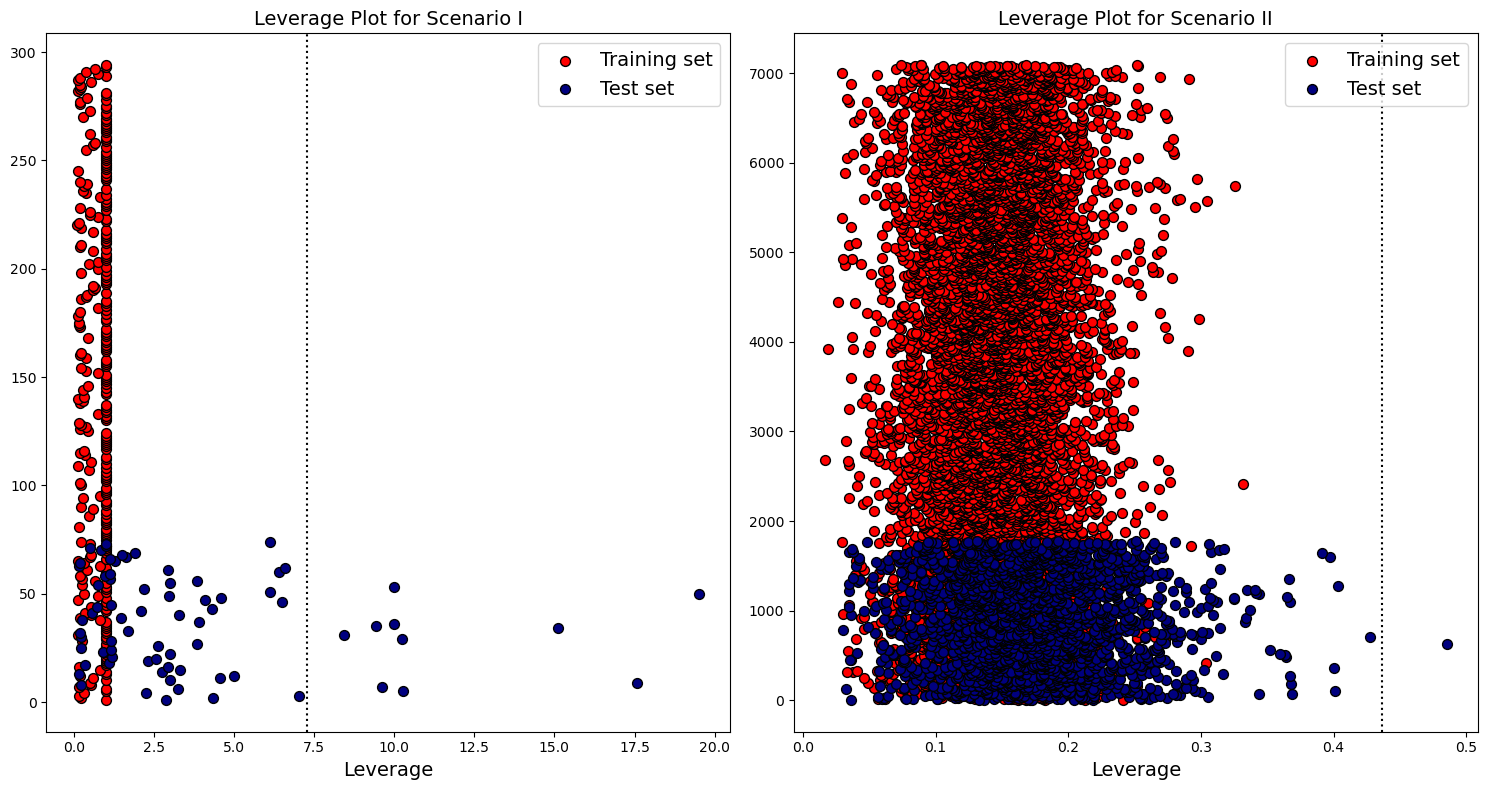

In [6]:
X1_train_scaled_ = X1_train_scaled.to_numpy()
X1_test_scaled_ = X1_test_scaled.to_numpy()

leverage_train_1 = np.diag(X1_train_scaled_ @ np.linalg.pinv(X1_train_scaled_.T @ X1_train_scaled_) @ X1_train_scaled_.T)
leverage_test_1 = np.diag(X1_test_scaled_ @ np.linalg.pinv(X1_train_scaled_.T @ X1_train_scaled_) @ X1_test_scaled_.T)

Y_train_1 = pd.DataFrame()
Y_train_1['leverage'] = leverage_train_1
Y_test_1 = pd.DataFrame()
Y_test_1['leverage'] = leverage_test_1


X2_train_scaled_ = X2_train_scaled.to_numpy()
X2_test_scaled_ = X2_test_scaled.to_numpy()

leverage_train_2 = np.diag(X2_train_scaled_ @ np.linalg.pinv(X2_train_scaled_.T @ X2_train_scaled_) @ X2_train_scaled_.T)
leverage_test_2 = np.diag(X2_test_scaled_ @ np.linalg.pinv(X2_train_scaled_.T @ X2_train_scaled_) @ X2_test_scaled_.T)

Y_train_2 = pd.DataFrame()
Y_train_2['leverage'] = leverage_train_2
Y_test_2 = pd.DataFrame()
Y_test_2['leverage'] = leverage_test_2


fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].scatter(Y_train_1['leverage'], range(1, X1_train_scaled.shape[0] + 1), color='red', label='Training set', marker='o', s=50, edgecolors='black')
axes[0].scatter(Y_test_1['leverage'], range(1, X1_test_scaled.shape[0] + 1), color='navy', label='Test set', marker='o', s=50, edgecolors='black')
axes[0].axvline(x=3 * (X1_train_scaled.shape[1] + 1) / (X1_train_scaled.shape[0]), color='black', linestyle='dotted')
axes[0].set_title('Leverage Plot for Scenario I', fontsize=14)
axes[0].set_xlabel('Leverage', fontsize = 14)
axes[0].legend(loc='upper right', fontsize = 14)

axes[1].scatter(Y_train_2['leverage'], range(1, X2_train_scaled.shape[0] + 1), color='red', label='Training set', marker='o', s=50, edgecolors='black')
axes[1].scatter(Y_test_2['leverage'], range(1, X2_test_scaled.shape[0] + 1), color='navy', label='Test set', marker='o', s=50, edgecolors='black')
axes[1].axvline(x=3 * (X2_train_scaled.shape[1] + 1) / (X2_train_scaled.shape[0]), color='black', linestyle='dotted')
axes[1].set_title('Leverage Plot for Scenario II', fontsize=14)
axes[1].set_xlabel('Leverage', fontsize = 14)
axes[1].legend(loc='upper right', fontsize = 14)

plt.tight_layout()
plt.show()


### 9. PIPELINE EVALUATION

In [7]:
jl_XGB2 = joblib.load('scene2_XGB.pkl')

model_final = XGBClassifier(**jl_XGB2.best_params, random_state = 36)
model_final.fit(X2_train_scaled, y2_train)


y_prob1 = model_final.predict_proba(X2_scaled)[:,1]
y_pred1 = (y_prob1 >= 0.7).astype(int)

X2_scaled_ = X2_scaled.to_numpy()
X2_train_scaled_ = X2_train_scaled.to_numpy()
leverage = np.diag(X2_scaled_ @ np.linalg.pinv(X2_train_scaled_.T @ X2_train_scaled_) @ X2_scaled_.T)

In [11]:
df_full = pd.read_csv('Similarity_result.csv')
docking = pd.read_csv('df_docking.csv')
leverage_threshold =3 * (X2_train_scaled.shape[1] + 1) / (X2_train_scaled.shape[0])

PandasTools.AddMoleculeColumnToFrame(df_full, 'SMILES','Structure')
df_full['Morgan'] = df_full['Structure'].apply(lambda mol:AllChem.GetMorganFingerprintAsBitVect (mol, 2, nBits=1024, useChirality=False) )
df_full['QSAR'] = y_prob1
df_full['Docking'] = docking.score
df_full['Leverage'] = leverage

cut_off_similarity = round(df_full.shape[0]*1/100)
df_full_sort = df_full.sort_values(by = 'tanimoto_morgan_tacrine', ascending=False).reset_index(drop = True).loc[:cut_off_similarity,:]

cut_off_docking = round(df_full_sort.shape[0]*10/100)
df_hit = df_full_sort[(df_full_sort['Leverage']<= leverage_threshold)& (df_full_sort['QSAR'] >= 0.70)].sort_values(by = 'Docking').iloc[:cut_off_docking,:]
df_hit

[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerator
[15:23:14] DEPRECATION WARNING: please use MorganGenerat

,Unnamed: 0,SMILES,Code,Class,Structure,Morgan,tanimoto_morgan_tacrine,QSAR,Docking,Leverage
25,73,COc1cc(C(=O)NCCCC(=O)NNc2c3c(nc4ccccc24)CCCC3)...,CHEMBL219063,Active,<rdkit.Chem.rdchem.Mol object at 0x73452c8e3290>,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.338462,0.970499,-11.030,0.073228
16,95,COc1cc(C(=O)NCC(=O)NNc2c3c(nc4ccccc24)CCCC3)cc...,CHEMBL385269,Active,<rdkit.Chem.rdchem.Mol object at 0x73452c8e3c30>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.360656,0.982476,-10.690,0.079758
24,103,COc1cc(CCC(=O)NCC(=O)NNc2c3c(nc4ccccc24)CCCC3)...,CHEMBL445846,Active,<rdkit.Chem.rdchem.Mol object at 0x73452c55c040>,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.338462,0.940231,-10.510,0.090494
37,94,COc1cc(CCC(=O)NCCCC(=O)NNc2c3c(nc4ccccc24)CCCC...,CHEMBL384886,Active,<rdkit.Chem.rdchem.Mol object at 0x73452c8e3bc0>,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.323529,0.983920,-10.190,0.085133
34,101,COc1cc(C(=O)NCCCCCC(=O)NNc2c3c(nc4ccccc24)CCCC...,CHEMBL434378,Active,<rdkit.Chem.rdchem.Mol object at 0x73452c8e3ed0>,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.328358,0.999542,-10.160,0.066626
35,72,COc1cc(C(=O)NCCCCCCCC(=O)NNc2c3c(nc4ccccc24)CC...,CHEMBL216159,Active,<rdkit.Chem.rdchem.Mol object at 0x73452c8e3220>,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.328358,0.999607,-9.633,0.066499
17,139,CC(=O)C(Cc1ccc(O)cc1)C(=O)NCCCCCCNc1c2c(nc3ccc...,CHEMBL4078137,Active,<rdkit.Chem.rdchem.Mol object at 0x73452c55d000>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.354839,0.894789,-9.248,0.074179
7,74,COc1cc(C(=O)NNc2c3c(nc4ccccc24)CCCC3)cc(OC)c1OC,CHEMBL219262,Active,<rdkit.Chem.rdchem.Mol object at 0x73452c8e3300>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.415094,0.978306,-9.162,0.070450
87,44,Cc1cccc(Nc2ccccc2C(=O)NCC(=O)NCCCNc2c3c(nc4cc(...,CHEMBL3221290,Active,<rdkit.Chem.rdchem.Mol object at 0x73452c8e25e0>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.259740,0.952196,-8.768,0.051730


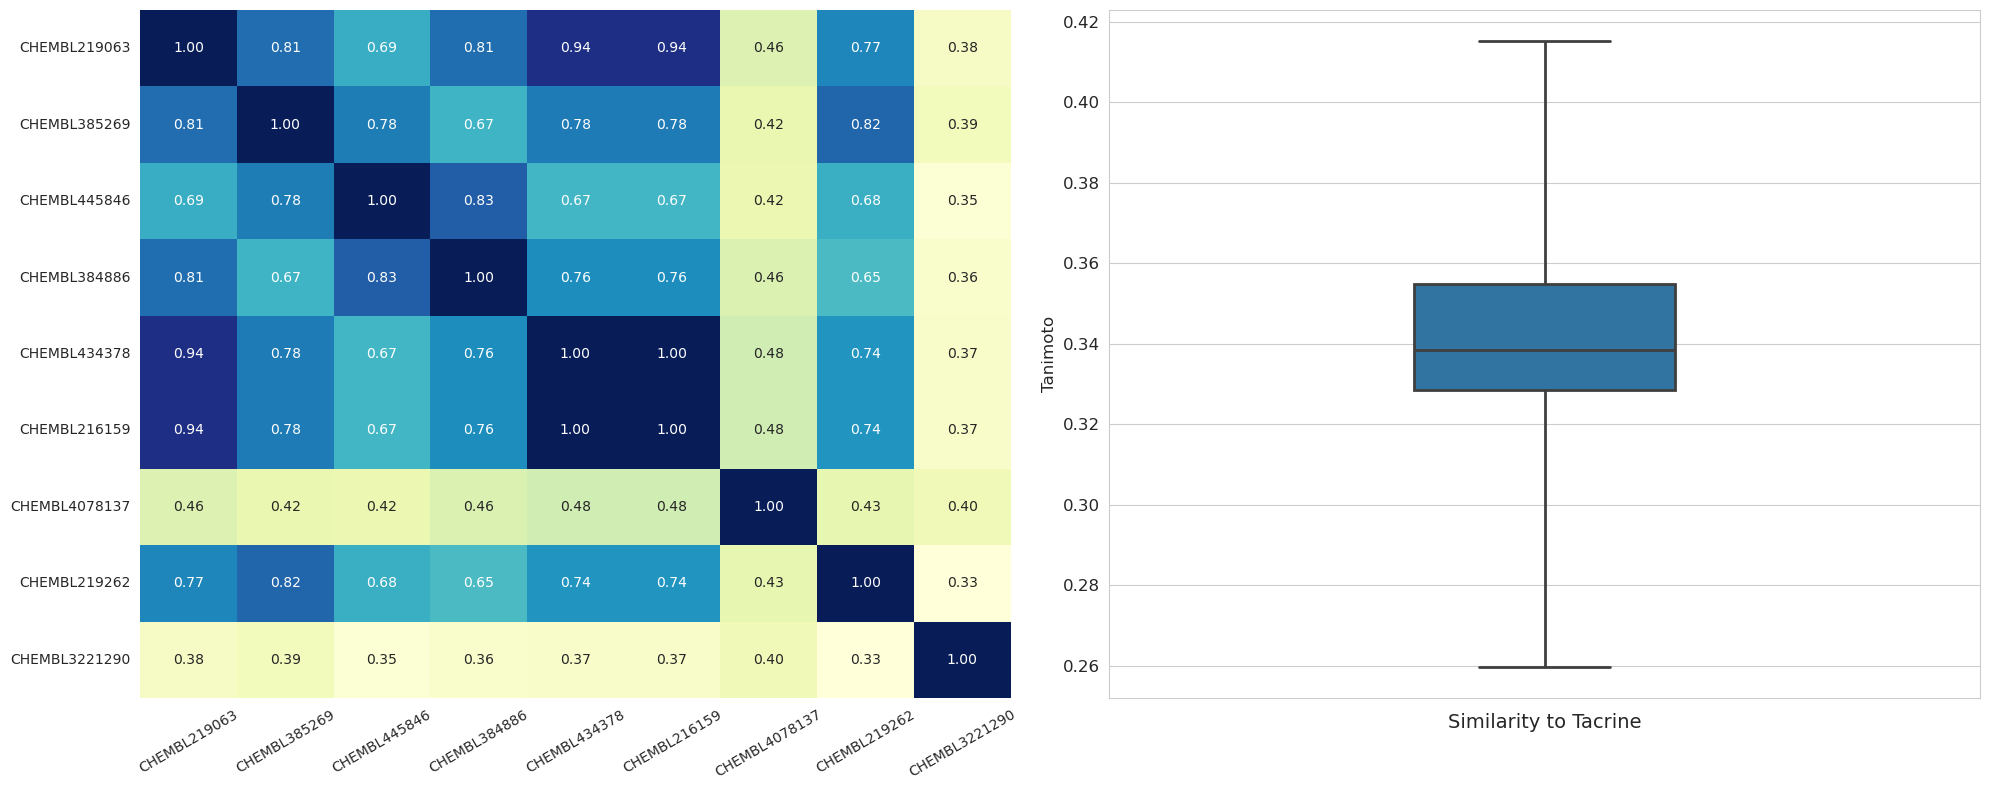

In [13]:
sns.set_style("whitegrid")

simi_mat = np.zeros((df_hit.shape[0], df_hit.shape[0]))

for i in range(df_hit.shape[0]):
    for j in range(df_hit.shape[0]):
        simi_mat[i, j] = DataStructs.TanimotoSimilarity(df_hit['Morgan'].iloc[i], df_hit['Morgan'].iloc[j])
        
fig, axes = plt.subplots(1, 2, figsize = (20,8))

sns.heatmap(simi_mat, annot=True, cmap="YlGnBu", fmt=".2f", cbar=False, ax=axes[0])
axes[0].set_xticks(np.arange(df_hit.shape[0]) + 0.5) 
axes[0].set_xticklabels(df_hit.Code, rotation=30)
axes[0].set_yticks(np.arange(df_hit.shape[0]) + 0.5)
axes[0].set_yticklabels(df_hit.Code, rotation = 0)

sns.boxplot(df_hit.tanimoto_morgan_tacrine, whis=[0, 100], ax=axes[1], width=0.3, linewidth=2)
axes[1].set_xlabel('Similarity to Tacrine', fontsize = 14)
axes[1].set_ylabel('Tanimoto', fontsize = 12)
axes[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()